In [18]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
import os
if not os.path.exists('/content/training'):
    !echo "Downloading files..."
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

    !echo "Unzipping files..."
    !unzip -q /content/training1.zip
    !unzip -q /content/training2.zip
    !unzip -q /content/holdout.zip
    !unzip -q /content/mini_holdout.zip

    # Combine the two traning directories
    !echo "Merging training data..."
    !mkdir /content/training
    !mv /content/training1/* /content/training
    !mv /content/training2/* /content/training

    # Cleanup
    !echo "Cleaning up..."
    !rmdir /content/training1
    !rmdir /content/training2
    !rm training1.zip
    !rm training2.zip
    !rm holdout.zip
    !rm mini_holdout.zip

    !echo "Data ready."

In [33]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score, ConfusionMatrixDisplay


In [20]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

from skimage import exposure

# def contrast_stretching(img):
#     p2, p98 = np.percentile(img, (2, 98))
#     img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
#     return img_rescale

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        brightness_range=[0.5, 1.5],
        # preprocessing_function=contrast_stretching
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        brightness_range=[0.5, 1.5],
        # preprocessing_function=contrast_stretching
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [21]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

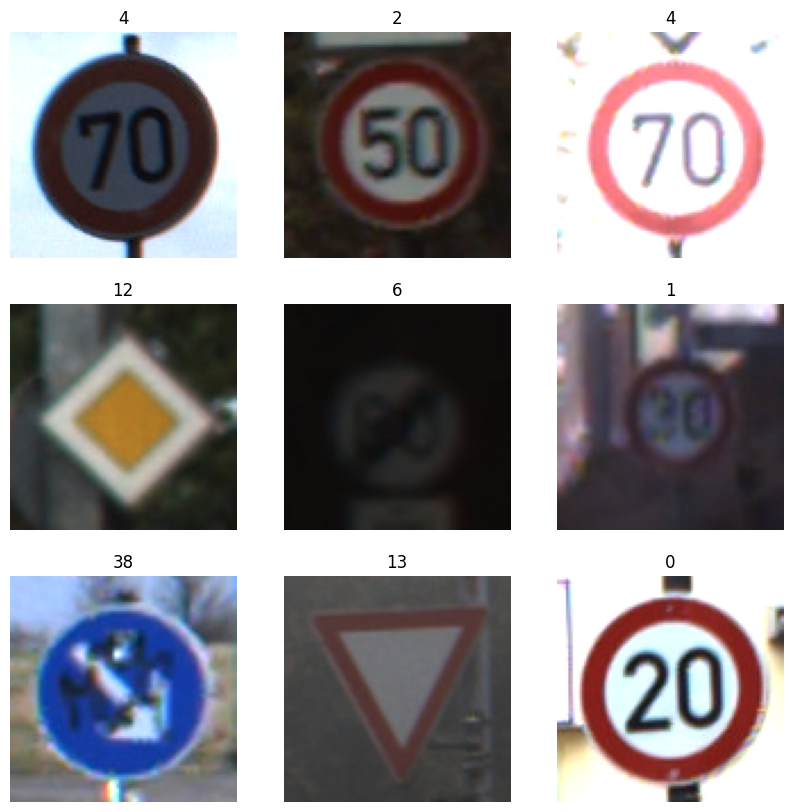

In [22]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

# Building Model

In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Added dropout layer for blurry photos

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Added dropout layer

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Added dropout layer

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Added dropout layer
model.add(Dense(len(target_names), activation='softmax'))

# Define the ReduceLROnPlateau callback
# This will slowly reduce our lr as we hit a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Training Model

In [25]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[reduce_lr])

Epoch 1/20
981/981 [==============================] - 50s 50ms/step - loss: 1.3043 - accuracy: 0.5787 - val_loss: 0.7476 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 2/20
981/981 [==============================] - 69s 70ms/step - loss: 0.7710 - accuracy: 0.7418 - val_loss: 0.4551 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 3/20
981/981 [==============================] - 46s 47ms/step - loss: 0.5827 - accuracy: 0.8078 - val_loss: 0.3843 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 4/20
981/981 [==============================] - 63s 65ms/step - loss: 0.4594 - accuracy: 0.8447 - val_loss: 0.3070 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 5/20
981/981 [==============================] - 48s 49ms/step - loss: 0.3752 - accuracy: 0.8747 - val_loss: 0.2392 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 6/20
981/981 [==============================] - 46s 47ms/step - loss: 0.3139 - accuracy: 0.8929 - val_loss: 0.2141 - val_accuracy: 0.9478 - lr: 0.0010
Epoch 7/20
981/981 [==============================] - 46s 

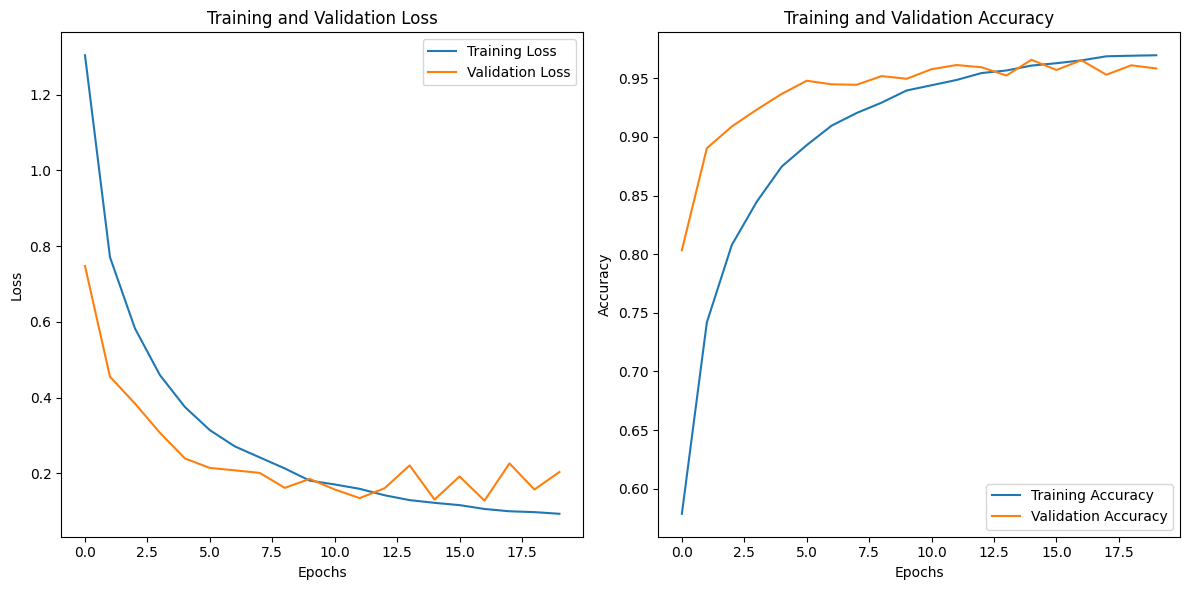

In [26]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Testing the model

Found 201 images belonging to 1 classes.
7/7 [==============================] - 0s 23ms/step
-------------------------------- RESULTS ---------------------------------

Accuracy: 96.01990049751244%



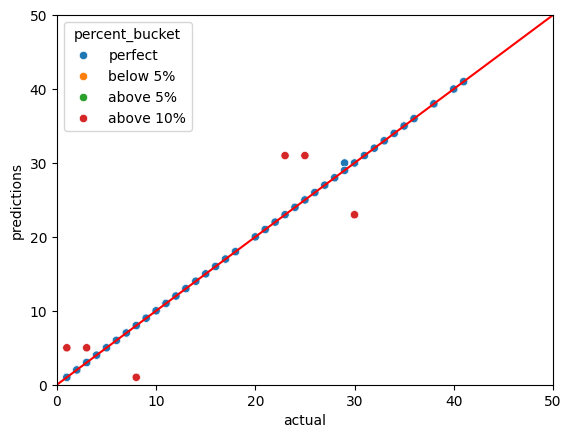

-----------------------------------------------------------------------------






In [31]:
# Load unlabeled images
test_dir = '/content/'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],
    target_size=image_size,
    class_mode=None,  # No class mode for unlabeled data
    shuffle=False
)

# Predict labels for unlabeled images
probabilities = model.predict(test_generator)
predictions = np.argmax(probabilities, axis=1)

# Load ground truth labels
answers_df = pd.read_csv('/content/mini_holdout_answers.csv')
ground_truth = answers_df['ClassId'].values

# Evaluate predictions
#precision = precision_score(ground_truth, predictions)
#recall = recall_score(ground_truth, predictions)
#f1 = f1_score(ground_truth, predictions)

# Calculate accuracy
correct_predictions = np.sum(predictions == ground_truth)
total_samples = len(ground_truth)
accuracy = correct_predictions / total_samples * 100


# Create a DataFrame for visualization
testfinal = pd.DataFrame({
    'actual': ground_truth,
    'predictions': predictions
})

# Add a column for percent_bucket (customize this based on your requirements)
testfinal['percent_bucket'] = pd.cut(
    abs((testfinal['actual'] - testfinal['predictions']) / testfinal['actual']),
    bins=[-np.inf, 0.05, 0.1, 0.2, np.inf],
    labels=['perfect', 'below 5%', 'above 5%', 'above 10%']
)

# Display results
print(f"-------------------------------- RESULTS ---------------------------------\n")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1: {f1}")
print(f"Accuracy: {accuracy}%\n")

color_dict = dict({'perfect': 'tab:blue', 'below 5%': 'tab:orange', 'above 5%': 'tab:green', 'above 10%': 'tab:red'})
ax = sns.scatterplot(data=testfinal, x='actual', y='predictions', hue="percent_bucket", palette=color_dict)
ax.plot([0, 1e3], [0, 1e3], color='r')

# Adjust axis limits
xlims = (0, 50)  # Modify as needed
ylims = (0, 50)  # Modify as needed
ax.set(xlim=xlims, ylim=ylims)

plt.show()
print(f"-" * 77)
print("\n" * 3)


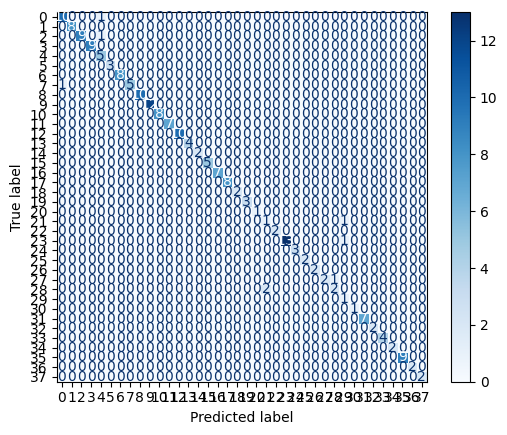

In [34]:
confusion_mat = confusion_matrix(ground_truth, predictions)
cm = ConfusionMatrixDisplay(confusion_mat)
cm.plot(cmap='Blues')

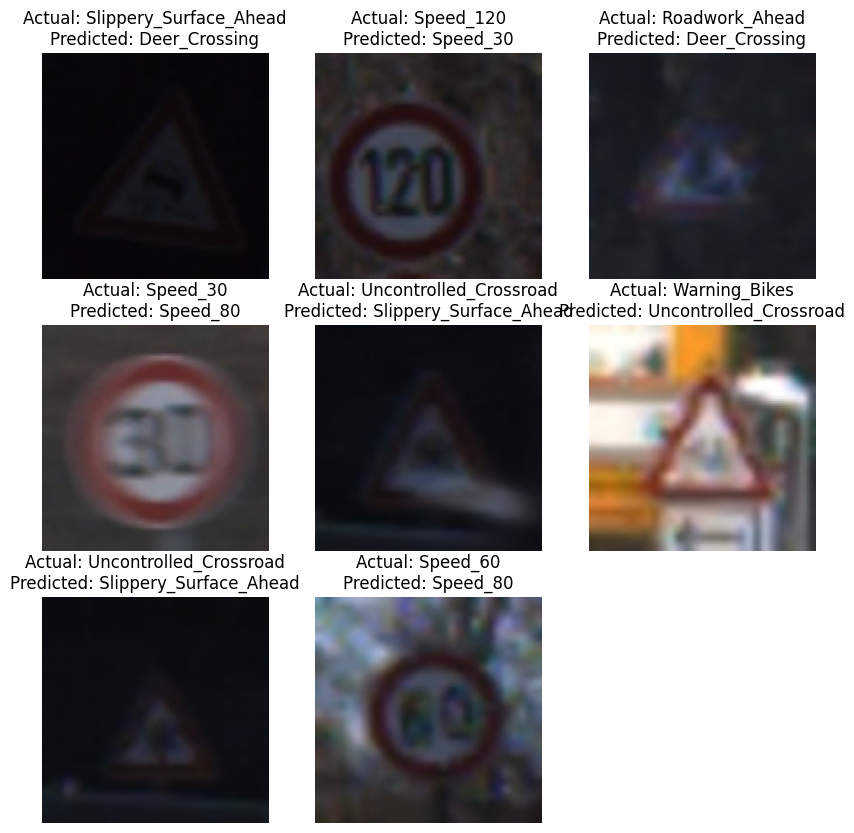

In [35]:
# Identify misclassified images
incorrect_predictions = testfinal[testfinal['actual'] != testfinal['predictions']]

# Display the misclassified images
plt.figure(figsize=(10, 10))
for i, (index, row) in enumerate(incorrect_predictions.iterrows()):
    if i >= 9:
        break
    image_path = test_generator.filenames[index]
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Actual: {target_names[row['actual']]}\nPredicted: {target_names[row['predictions']]}")
    plt.axis("off")

plt.show()


##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```